In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("ticks")

## Recycling Robot example
This notebook is inspired by the "Recycling Robot" example from
> Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press. [link](http://incompleteideas.net/book/the-book-2nd.html)

Suppose we have a robot going anywhere in an office searching for empty cans to trash them into a bin. The robot rechargerable battery can be `high` or `low`, but the robot can eventually be broken and cannot be repaired. During its cycle, the robot can search for empty cans in the office, remain stationary and wait, or head back to its charging base and recharge.  However, if it is broken, it can do nothing. The robot activity is measured by a scoring system, providing a high score when it secures an empty can and a negative score when the battery goes low.

- **State space**: {`high`, `low`, `broken`}
- **Action space**: {`search`, `wait`, `recharge`}
- **Rewards**: $r_{search} = 3, r_{wait} = 1, r_{depleted} = -3, r_{broken} = 0$
- **Probabilities**: $\alpha$ (search to high), $\beta$ (search to low), $\gamma$ (to broken)

In [2]:
r_search = 3
r_wait = 1
r_depleted = -3
r_broken = 0
alpha = 0.4
beta = 0.6
gamma = 0.3

### Initialize `relearn` environment

In [3]:
from relearn.agent import *
from relearn.environment import *
from relearn.mdp import *

In [4]:
actions = [Action(name) for name in ["search", "wait", "recharge"]]
states = [State(name) for name in ["low", "high", "broken"]]
states[-1].end_state = True  # sets the state 'broken' as end state
states[1].start_state = True  # sets the state 'high' as start state
rewards = [Reward(value) for value in [r_search, r_wait, r_broken, r_depleted]]

In [5]:
transitions = [
    Transition(
        start_state_name="low",
        action_name="search",
        landing_state_name="low",
        reward_value=r_search,
        probability=beta,
    ),
    Transition("low", "search", "high", r_depleted, 1 - beta - gamma),
    Transition("low", "search", "broken", r_broken, gamma),
    Transition("low", "wait", "low", r_wait, 1 - gamma),
    Transition("low", "wait", "broken", r_broken, gamma),
    Transition("low", "recharge", "high", 0, 1 - gamma),
    Transition("low", "recharge", "broken", r_broken, gamma),
    Transition("high", "search", "low", r_search, 1 - alpha - gamma),
    Transition("high", "search", "high", r_search, alpha),
    Transition("high", "search", "broken", r_broken, gamma),
    Transition("high", "wait", "high", r_wait, 1 - gamma),
    Transition("high", "wait", "broken", r_broken, gamma),
]

#### See the tabular environment

In [6]:
T = pd.DataFrame([{
    's': t.start_state, 'a': t.action, 
    's_prime': t.end_state, 'p': t.probability, 
    'r': t.reward
} for t in transitions])
T 

,s,a,s_prime,p,r
0,low,search,low,0.6,3
1,low,search,high,0.1,-3
2,low,search,broken,0.3,0
3,low,wait,low,0.7,1
4,low,wait,broken,0.3,0
5,low,recharge,high,0.7,0
6,low,recharge,broken,0.3,0
7,high,search,low,0.3,3
8,high,search,high,0.4,3
9,high,search,broken,0.3,0


### Create Environment, Agent and MDP

In [7]:
environment = Environment(states=states, actions=actions, rewards=rewards, transitions=transitions)

In `relearn` the agent is nothing more than a way to run a policy

In [8]:
random_policy = Policy.random_policy(n_states=len(environment.states), n_actions=len(environment.actions))
agent = Agent(policy=random_policy)

In [9]:
action = random_policy.select_action(states[0])
print("In state {} do {}".format(states[0].name, action.name))
pi = pd.DataFrame(random_policy.state_action_probas, index=[s.name for s in states], columns=[a.name for a in actions])
pi

In state low do recharge


,search,wait,recharge
low,0.270416,0.480245,0.249339
high,0.463207,0.100962,0.435831
broken,0.232304,0.677173,0.090523


The MDP orchestrates the interation with the environment

In [10]:
mdp = MDP(agent=Agent(policy=random_policy), environment=environment)
for i in range(4):
    mdp.iterate()
    mdp.print_trajectory()

Reward: 0	State: high	Action: search
Reward: 3	State: low
Reward: 0	State: high	Action: search
Reward: 3	State: low	Action: wait
Reward: 0	State: broken
End state was met.
Reward: 0	State: high	Action: search
Reward: 3	State: low	Action: wait
Reward: 0	State: broken
End state was met.
Reward: 0	State: high	Action: search
Reward: 3	State: low	Action: wait
Reward: 0	State: broken


### Evaluation of random policy
**Iterative Policy Evaluation**

- Init $V(s)$ arbitrarly except for $V(\textrm{terminal}) = 0$
- Init $\theta$ as a threshold to stop iteration
- While $\Delta > \theta$:
  - For each $s \in S$:
    - $v \leftarrow V(s)$
    - $V(s) \leftarrow \sum\limits_{a \in A} \pi(a \mid s) \sum\limits_{s' \in  S, r \in R} p(s', r \mid s, a)\left[r + \gamma V(s')\right]$
    - $\Delta \leftarrow \max(\Delta, \mid v - V(s)\mid)$

In [11]:
import dp 

In [12]:
mdp = MDP(agent=Agent(policy=random_policy), environment=environment)

In [13]:
V, history = dp.policy_evaluation(mdp=mdp, gamma=.9, theta=0.0001)

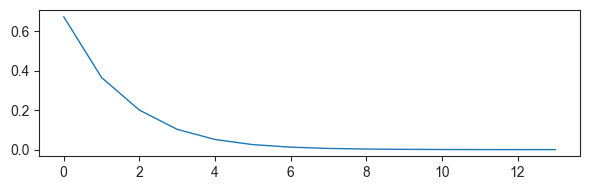

In [14]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.lineplot(history, ax=ax, linewidth=1, markers=True, dashes=False)
plt.tight_layout()
plt.show()

In [15]:
pd.DataFrame(V, index=[s.name for s in sorted(mdp.environment.states, key=lambda x: x.idx)]).T

,low,high,broken
0,1.892374,1.663213,0.0


### Find optimal policy by policy iteration and policy evaluation

In [16]:
mdp = MDP(agent=Agent(policy=random_policy), environment=environment)
pi, V, history = dp.policy_iteration(mdp=mdp, gamma=.9)

In [17]:
pd.DataFrame(V, index=[s.name for s in sorted(mdp.environment.states, key=lambda x: x.idx)]).T

,low,high,broken
0,4.252771,5.075083,0.0


In [18]:
def show_policy(pi):
    return [(s.name, a.name) for s, a in pi.items()]

In [19]:
for p in history:
    print(show_policy(p))

[('low', 'search'), ('high', 'search'), ('broken', 'recharge')]
[('low', 'search'), ('high', 'search'), ('broken', 'search')]


## Value iteration

- Init $V(s)$ arbitrarly except for $V(\textrm{terminal}) = 0$
- Init $\theta$ as a threshold to stop iteration
- While $\Delta > \theta$:
  - For each $s \in S$:
    - $v \leftarrow V(s)$
    - $V(s) \leftarrow \max\limits_{a \in A}\left( \sum\limits_{s' \in  S, r \in R} p(s', r \mid s, a)\left[r + \gamma V(s')\right] \right )$
    - $\Delta \leftarrow \max(\Delta, \mid v - V(s)\mid)$
- $\pi(s) \leftarrow \arg\max\limits_{a \in A} \left( \sum\limits_{s' \in  S, r \in R} p(s', r \mid s, a)\left[r + \gamma V(s')\right] \right )$

In [20]:
mdp = MDP(agent=Agent(policy=random_policy), environment=environment)
pi, V, history = dp.value_iteration(mdp=mdp, gamma=.9)

In [21]:
pd.DataFrame(V, index=[s.name for s in sorted(mdp.environment.states, key=lambda x: x.idx)]).T

,low,high,broken
0,4.252739,5.075062,0.0


In [22]:
show_policy(pi)

[('low', 'search'), ('high', 'search'), ('broken', 'search')]